# **Proyecto 7: Técnicas avanzadas para ciencia de datos y empleabilidad**

## Objetivos
- Aplicar exitosamente todos los conocimientos que has adquirido a lo largo del bootcamp
- Consolidar las técnicas de limpieza, entrenamiento, gráficación y ajuste a modelos de Machine Learning
- Generar una API que pueda dar predicciones como resultado a partir de datos enviados


## Proyecto

1. Se trabajará con el siguiente dataset:
  - Demograficos de los ganadores del premio Oscar de la Academia: https://www.kaggle.com/datasets/fmejia21/demographics-of-academy-awards-oscars-winners

2. Analísis exploratorio y limpieza de los datos.

3. Entrenamiento del modelo de Machine Learning.

4. Generacion por lo menos 2 gráficas y 2 métricas de rendimeiento; explicación de las puntuaciones de rendimiento que ameriten para tu problema.


### Dataset

#### Librerias necesarias

Se importa las librerias que se necesitan para la realización del proyecto

In [6]:
#importamos las librerias necesarias
import pandas as pd
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import confusion_matrix, classification_report

from yellowbrick.cluster import KElbowVisualizer 
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",200)

In [7]:
#Instalacion de la libreria pycountry-convert, para poder hacer convertir, desde el pais de origen al continente de origen
!pip install pycountry-convert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
#Importacion de la libreria pycountry
import pycountry_convert as pc

In [9]:
#Funcion para convertir el pais a continente
def country_to_continent(country_name):
    country_alpha2 = pc.country_name_to_country_alpha2(country_name)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    country_continent_name = pc.convert_continent_code_to_continent_name(country_continent_code)
    return country_continent_name



In [10]:
#Funcion que nos valida el rendimiento de modelos de clusters
def scoringClusterValidation(k, df, model):
  model2 = []
  s_score2 = []
  b= []
  ch_score2= []
  db_score2 = []
  df3 = df
  for i in range(k):
    a= i+2
    b.append(a)
    #AgglomerativeClustering(n_clusters = a, affinity = "euclidean", linkage = "ward")
    if model == KMeans:
      model1 = (KMeans(n_clusters=a, random_state=19).fit(df3))
    else:
      model1 = (model(n_clusters=a).fit(df3))
    model2.append(model1)
    labels = (model1.labels_) #Con esto obtenemos a qué cluster corresponde cada fila
    s_score2.append(silhouette_score(df3, labels, metric='euclidean'))
    ch_score = calinski_harabasz_score(df3, labels) #No usa el parámetro metric.
    ch_score2.append(ch_score)
    db_score = davies_bouldin_score(df3, labels) #No usa el parámetro metric.
    db_score2.append(db_score)
    df_score = pd.DataFrame(b, columns= ['K'])
  df_score['Siluete-score'] = s_score2
  df_score["Calinski-Harabasz"] = ch_score2
  df_score["Davies-Bouldin"] = db_score2
  print(df_score.head(k))
  print('------------------------------------------------------------------')
  #Se hallará el valor sugerido, según el Siluete score. Este es el K con mayor scoring.
  maximo_Siluete = df_score["Siluete-score"].max()
  siluete = df_score.loc[:, ["K"]][df_score["Siluete-score"] == maximo_Siluete]
  siluete = int(siluete.values[0])
  print(f'El valor del Siluete es {siluete}')

  #Se hallará el valor sugerido, según Calinski-Harabasz. Este es el K con mayor scoring.
  maximo_Calinski = df_score["Calinski-Harabasz"].max()
  calinski = df_score.loc[:, ["K"]][df_score["Calinski-Harabasz"] == maximo_Calinski]
  calinski = int(calinski.values[0])
  print(f'El valor Calinski-Harabasz es {calinski}')

  #Se hallará el valor sugerido, según Davies-Bouldin. Este es el K con menor scoring.
  minimo_Davies = df_score["Davies-Bouldin"].min()
  davies = df_score.loc[:, ["K"]][df_score["Davies-Bouldin"] == minimo_Davies]
  davies = int(davies.values[0])
  print(f'El valor Davies-Bouldin es {davies}')
  print('------------------------------------------------------------------')

  #Se hará una ponderación, que según los scoring y el K hallado por el diagrama de codo. Esto para ver cual es el K con mayor "votación"
  km = 4
  ks = pd.DataFrame({})
  if model == KMeans:
    ks['Valores K'] = [siluete, calinski, davies, km]
  else:
    ks['Valores K'] = [siluete, calinski, davies]
  print(ks.value_counts())

#### Carga Dataset

In [11]:
#Conexion a google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
df=pd.read_csv("/content/drive/MyDrive/1. DataScienci/proyectoModulo_7/Oscars-demographics-DFE.csv", encoding='latin-1')

### Analísis exploratorio y limpieza de los datos.


In [13]:
df.head(500)

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,birthplace,birthplace:confidence,date_of_birth,date_of_birth:confidence,race_ethnicity,race_ethnicity:confidence,religion,religion:confidence,sexual_orientation,sexual_orientation:confidence,year_of_award,year_of_award:confidence,award,biourl,birthplace_gold,date_of_birth_gold,movie,person,race_ethnicity_gold,religion_gold,sexual_orientation_gold,year_of_award_gold
0,670454353,False,finalized,3,2/10/15 3:45,"Chisinau, Moldova",1.0,30-Sep-1895,1.0,White,1.0,Na,1.0,Straight,1.0000,1927,1.0000,Best Director,http://www.nndb.com/people/320/000043191/,NaN,NaN,Two Arabian Knights,Lewis Milestone,NaN,NaN,NaN,NaN
1,670454354,False,finalized,3,2/10/15 2:03,"Glasgow, Scotland",1.0,2-Feb-1886,1.0,White,1.0,Na,1.0,Straight,0.6842,1930,1.0000,Best Director,http://www.nndb.com/people/626/000042500/,NaN,NaN,The Divine Lady,Frank Lloyd,NaN,NaN,NaN,NaN
2,670454355,False,finalized,3,2/10/15 2:05,"Chisinau, Moldova",1.0,30-Sep-1895,1.0,White,1.0,Na,1.0,Straight,1.0000,1931,0.6667,Best Director,http://www.nndb.com/people/320/000043191/,NaN,NaN,All Quiet on the Western Front,Lewis Milestone,NaN,NaN,NaN,NaN
3,670454356,False,finalized,3,2/10/15 2:04,"Chicago, Il",1.0,23-Feb-1899,1.0,White,1.0,Na,1.0,Straight,1.0000,1932,1.0000,Best Director,http://www.nndb.com/people/544/000041421/,NaN,NaN,Skippy,Norman Taurog,NaN,NaN,NaN,NaN
4,670454357,False,finalized,3,2/10/15 1:48,"Salt Lake City, Ut",1.0,23-Apr-1894,1.0,White,1.0,Roman Catholic,1.0,Straight,1.0000,1933,1.0000,Best Director,http://www.nndb.com/people/292/000044160/,NaN,NaN,Bad Girl,Frank Borzage,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,670946276,False,finalized,3,2/10/15 2:00,"London, England",1.0,7-Mar-71,1.0,White,1.0,Jewish,1.0,Straight,1.0000,2006,0.6857,Best Supporting Actress,http://www.nndb.com/people/309/000032213/,NaN,NaN,The Constant Gardener,Rachel Weisz,NaN,NaN,NaN,NaN
437,670946299,False,finalized,3,2/10/15 2:04,"Manchester, England",1.0,20-Oct-56,1.0,White,1.0,Roman Catholic,1.0,Straight,1.0000,2009,1.0000,Best Director,http://www.nndb.com/people/887/000044755/,NaN,NaN,Slumdog Millionaire,Danny Boyle,NaN,NaN,NaN,NaN
438,670964912,False,finalized,3,2/10/15 2:03,"Chicago, Il",1.0,26-Jul-22,1.0,White,1.0,Na,1.0,Straight,1.0000,1977,1.0000,Best Supporting Actor,http://www.nndb.com/people/224/000032128/,NaN,NaN,All the President's Men,Jason Robards,NaN,NaN,NaN,NaN
439,670964956,False,finalized,3,2/10/15 2:01,"Laurel, Ne",1.0,31-Aug-28,1.0,White,1.0,Na,1.0,Straight,1.0000,1999,1.0000,Best Supporting Actor,http://www.nndb.com/people/764/000022698/,NaN,NaN,Affliction,James Coburn,NaN,NaN,NaN,NaN


In [14]:
#Cantidad de columnas y filas del dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 441 entries, 0 to 440
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   _unit_id                       441 non-null    int64  
 1   _golden                        441 non-null    bool   
 2   _unit_state                    441 non-null    object 
 3   _trusted_judgments             441 non-null    int64  
 4   _last_judgment_at              416 non-null    object 
 5   birthplace                     441 non-null    object 
 6   birthplace:confidence          441 non-null    float64
 7   date_of_birth                  441 non-null    object 
 8   date_of_birth:confidence       441 non-null    float64
 9   race_ethnicity                 441 non-null    object 
 10  race_ethnicity:confidence      441 non-null    float64
 11  religion                       441 non-null    object 
 12  religion:confidence            441 non-null    flo

In [15]:
df.describe()

,_unit_id,_trusted_judgments,birthplace:confidence,date_of_birth:confidence,race_ethnicity:confidence,religion:confidence,sexual_orientation:confidence,year_of_award,year_of_award:confidence,year_of_award_gold
count,4.410000e+02,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000,11.000000
mean,6.704825e+08,7.637188,0.995259,0.996607,0.999130,0.989373,0.992390,1973.165533,0.990082,1977.363636
std,1.139974e+05,19.015541,0.038917,0.032060,0.016438,0.065610,0.049458,24.030895,0.059177,21.592928
min,6.704544e+08,3.000000,0.657100,0.656200,0.657100,0.333300,0.657100,1927.000000,0.333300,1942.000000
25%,6.704545e+08,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1953.000000,1.000000,1964.000000
50%,6.704546e+08,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1973.000000,1.000000,1977.000000
75%,6.704547e+08,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1994.000000,1.000000,1997.000000
max,6.709729e+08,95.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2014.000000,1.000000,2006.000000


In [16]:
#Revision de las categorias premiadas
df['award'].value_counts()

Best Actress               95
Best Director              91
Best Actor                 88
Best Supporting Actress    85
Best Supporting Actor      82
Name: award, dtype: int64

In [17]:
#Revision de las categorias premiadas
df['religion'].value_counts()

Na                       269
Roman Catholic            61
Jewish                    50
Atheist                   16
Born-Again Christian       5
Baptist                    5
Buddhist                   5
Protestant                 5
Christian Science          4
Deist                      3
Lutheran                   3
Christian                  2
Quaker                     2
Anglican/episcopalian      2
Presbyterian               2
See Note                   1
Sufism                     1
Disciples of Christ        1
Hindu                      1
Methodist                  1
Agnostic                   1
Congregationalist          1
Name: religion, dtype: int64

In [18]:
#Revision de la orientacion sexual
df['sexual_orientation'].value_counts()

Straight             397
Bisexual              21
Na                    11
Gay                    7
Matter of Dispute      3
Lesbian                2
Name: sexual_orientation, dtype: int64

In [19]:
#Raza etnica
df['race_ethnicity'].value_counts()

White             411
Black              15
Hispanic            8
Asian               4
Multiracial         2
Middle Eastern      1
Name: race_ethnicity, dtype: int64

In [20]:
#Verificamos la completitud de las variables
completitud = pd.DataFrame(df.isnull().sum())
completitud.reset_index(inplace = True)
completitud = completitud.rename(columns = {"index":"columna",0:"total"})
completitud["completitud"] = (1 - completitud["total"] / df.shape[0]) * 100
completitud = completitud.sort_values(by = "completitud", ascending = True)
completitud.reset_index(drop = True, inplace = True)
completitud

,columna,total,completitud
0,race_ethnicity_gold,439,0.453515
1,sexual_orientation_gold,438,0.680272
2,date_of_birth_gold,433,1.814059
3,birthplace_gold,432,2.040816
4,religion_gold,431,2.267574
5,year_of_award_gold,430,2.494331
6,_last_judgment_at,25,94.331066
7,person,0,100.000000
8,movie,0,100.000000
9,biourl,0,100.000000


In [21]:
#Eliminar las variables cuya completitud sea menor al 80%
null_cols=list(completitud[completitud["completitud"]<80]["columna"].values)
df=df.drop(columns=null_cols)

In [22]:
#Verificamos la completitud de las variables
completitud = pd.DataFrame(df.isnull().sum())
completitud.reset_index(inplace = True)
completitud = completitud.rename(columns = {"index":"columna",0:"total"})
completitud["completitud"] = (1 - completitud["total"] / df.shape[0]) * 100
completitud = completitud.sort_values(by = "completitud", ascending = True)
completitud.reset_index(drop = True, inplace = True)
completitud

,columna,total,completitud
0,_last_judgment_at,25,94.331066
1,_unit_id,0,100.000000
2,biourl,0,100.000000
3,award,0,100.000000
4,year_of_award:confidence,0,100.000000
5,year_of_award,0,100.000000
6,sexual_orientation:confidence,0,100.000000
7,sexual_orientation,0,100.000000
8,religion:confidence,0,100.000000
9,religion,0,100.000000


In [23]:
#Reemplazar manualmente el dato de la fila 54 de la columna 'date_of_birth', ya que no esta en el mismo formato que las otras
df.loc[54, 'date_of_birth'] = '18-Aug-1936'

In [24]:
#Convertir los datos de la columna en datos tipo fecha
df["date_of_birth"] = pd.to_datetime(df["date_of_birth"])

In [25]:
#Crear nueva columna, solo con el año de nacimiento
df['year_of_birth2'] = df['date_of_birth'].dt.year 

In [26]:
#Por tener diferentes formatos, algunos datos se deben aproximar al valor real
df.loc[df['year_of_birth2'] > 2000, 'year_of_birth'] = df['year_of_birth2'] -100
df.loc[df['year_of_birth2'] < 2000, 'year_of_birth'] = df['year_of_birth2']

In [27]:
#Se eliminan columnas incesarias, que no aportan valor a los datos, ya que son columnas que solo verifican la veracidad de los datos, siendo la mayoria '1'
#Tambien se eliminan columnas como url
df = df.drop(columns = ['_unit_id', '_trusted_judgments', '_last_judgment_at', 'birthplace:confidence', 'date_of_birth:confidence', 'race_ethnicity:confidence', 'religion:confidence', 'sexual_orientation:confidence', 'year_of_award:confidence', 'biourl', 'year_of_birth2', '_golden', '_unit_state'])

In [28]:
#Se crea una variable, que diga la edad de la persona, al dia que recibió el premio
df['age_of_award'] = df['year_of_award'] - df['year_of_birth']

In [29]:
df['birthplace2'] = df['birthplace']

In [30]:
#Normalizacion de los datos en lugar de nacimiento, los datos que tienen solo dos letras al final, antes del espacio, son estados de Estados Unidos
for i in range(len(df['birthplace'])):
  if df['birthplace'][i][-3:-2] == ' ':
    df['birthplace2'][i] = 'United States of America'

In [31]:
#Se divide la columna 'birthplace2' por columnas, separadas por comas (,), donde, la ultima columna con datos de cada fila, es el pais de nacimiento
new = df['birthplace2'].str.split(", ", n = 3, expand = True)

In [32]:
#La ultima columna con datos de cada fila, se agrega como lugar de nacimiento, el pais.
for i in range(len(df['birthplace2'])):
  if new[3][i] is None:
    if new[2][i] is None:
      if new[1][i] is None:
        df['birthplace2'][i] = new[0][i]
      else:
        df['birthplace2'][i] = new[1][i]
    else:
      df['birthplace2'][i] = new[2][i]
  else:
      df['birthplace2'][i] = new[3][i]

In [33]:
#Tranformacion del lugar de nacimiento, del equivalente de algunos paises.
for i in range(len(df['birthplace2'])):
  if df['birthplace2'][i] == 'New York City':
    df['birthplace2'][i] = 'United States of America'
  elif df['birthplace2'][i] == 'Moldova':
    df['birthplace2'][i] = 'Romania'
  elif df['birthplace2'][i] == 'Scotland':
    df['birthplace2'][i] = 'United Kingdom'
  elif df['birthplace2'][i] == 'England':
    df['birthplace2'][i] = 'United Kingdom'
  elif df['birthplace2'][i] == 'Ireland':
    df['birthplace2'][i] = 'United Kingdom'
  elif df['birthplace2'][i] == 'Wales':
    df['birthplace2'][i] = 'United Kingdom'
  elif df['birthplace2'][i] == 'Czechoslovakia':
    df['birthplace2'][i] = 'Slovakia'
  elif df['birthplace2'][i] == 'Canary Islands':
    df['birthplace2'][i] = 'Spain'
  elif df['birthplace2'][i] == 'Na':
    df['birthplace2'][i] = 'Austria'

In [34]:
df['birthplace2'].unique()

array(['Romania', 'United Kingdom', 'United States of America', 'Italy',
       'France', 'Hungary', 'Austria', 'Turkey', 'Germany', 'Japan',
       'Slovakia', 'Canada', 'New Zealand', 'Taiwan', 'Switzerland',
       'Ukraine', 'Puerto Rico', 'Russia', 'Australia', 'Mexico',
       'Cambodia', 'Spain', 'India', 'Sweden', 'Belgium', 'South Africa',
       'Israel', 'Greece'], dtype=object)

In [35]:
#Ejecucion de la fucion para convertir paises a continentes
df['Continent'] = df['birthplace2'].apply(lambda country_name: country_to_continent(country_name))

In [36]:
df.head(441)

,birthplace,date_of_birth,race_ethnicity,religion,sexual_orientation,year_of_award,award,movie,person,year_of_birth,age_of_award,birthplace2,Continent
0,"Chisinau, Moldova",1895-09-30,White,Na,Straight,1927,Best Director,Two Arabian Knights,Lewis Milestone,1895.0,32.0,Romania,Europe
1,"Glasgow, Scotland",1886-02-02,White,Na,Straight,1930,Best Director,The Divine Lady,Frank Lloyd,1886.0,44.0,United Kingdom,Europe
2,"Chisinau, Moldova",1895-09-30,White,Na,Straight,1931,Best Director,All Quiet on the Western Front,Lewis Milestone,1895.0,36.0,Romania,Europe
3,"Chicago, Il",1899-02-23,White,Na,Straight,1932,Best Director,Skippy,Norman Taurog,1899.0,33.0,United States of America,North America
4,"Salt Lake City, Ut",1894-04-23,White,Roman Catholic,Straight,1933,Best Director,Bad Girl,Frank Borzage,1894.0,39.0,United States of America,North America
...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,"London, England",2071-03-07,White,Jewish,Straight,2006,Best Supporting Actress,The Constant Gardener,Rachel Weisz,1971.0,35.0,United Kingdom,Europe
437,"Manchester, England",2056-10-20,White,Roman Catholic,Straight,2009,Best Director,Slumdog Millionaire,Danny Boyle,1956.0,53.0,United Kingdom,Europe
438,"Chicago, Il",2022-07-26,White,Na,Straight,1977,Best Supporting Actor,All the President's Men,Jason Robards,1922.0,55.0,United States of America,North America
439,"Laurel, Ne",2028-08-31,White,Na,Straight,1999,Best Supporting Actor,Affliction,James Coburn,1928.0,71.0,United States of America,North America


In [37]:
CX = df['Continent'].unique()
CY = df['Continent'].value_counts(sort=False)

In [38]:
BX = df['birthplace2'].unique()
BY = df['birthplace2'].value_counts(sort=False)

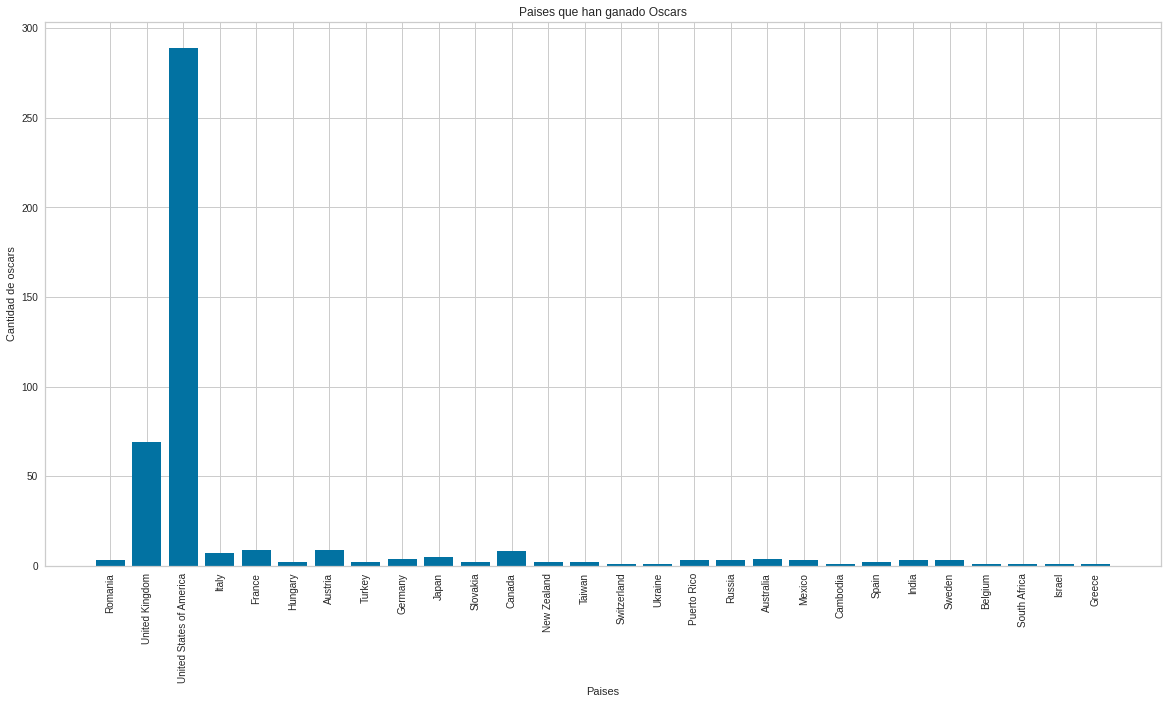

In [39]:
plt.figure(figsize=(20,10))
plt.bar(BX, BY, color= 'b')
plt.title('Paises que han ganado Oscars')
plt.xlabel('Paises')
plt.ylabel('Cantidad de oscars')
plt.xticks(rotation = 90)
plt.show()

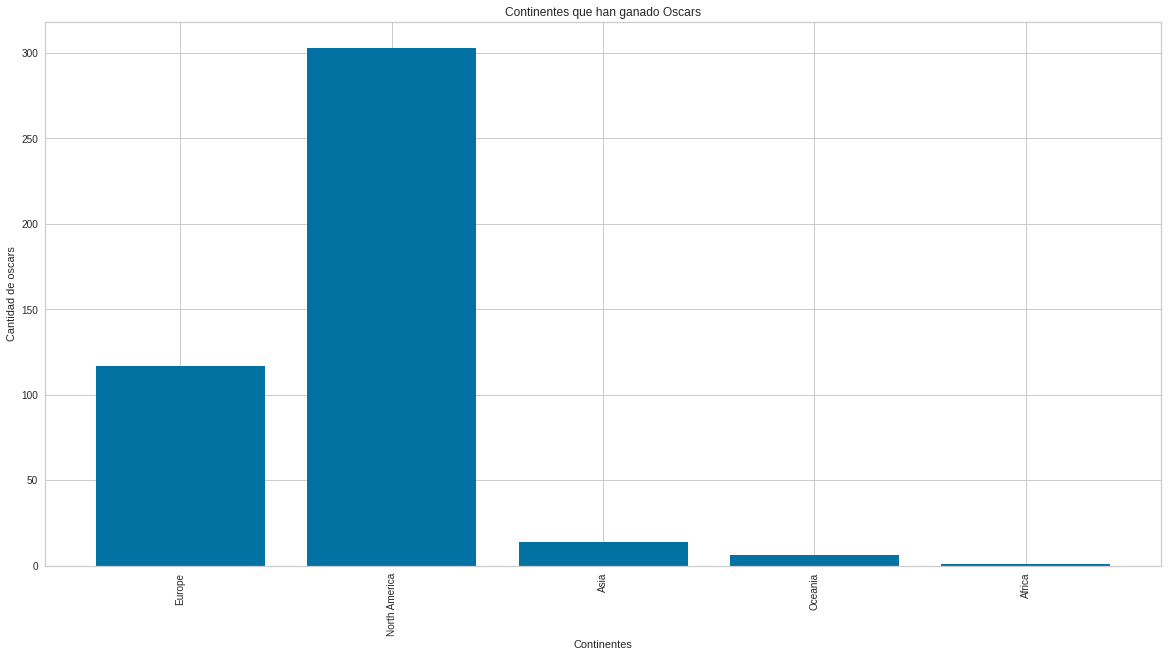

In [40]:
plt.figure(figsize=(20,10))
plt.bar(CX, CY, color= 'b')
plt.title('Continentes que han ganado Oscars')
plt.xlabel('Continentes')
plt.ylabel('Cantidad de oscars')
plt.xticks(rotation = 90)
plt.show()

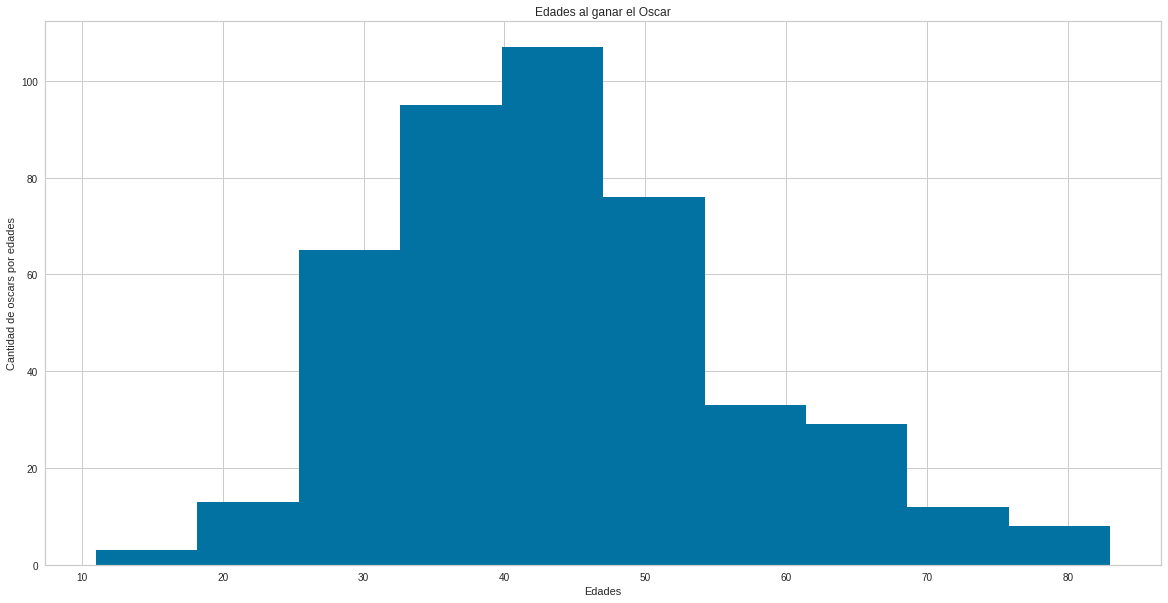

In [41]:
plt.figure(figsize=(20,10))
plt.hist(df['age_of_award'])
plt.title('Edades al ganar el Oscar')
plt.xlabel('Edades')
plt.ylabel('Cantidad de oscars por edades')
plt.show()

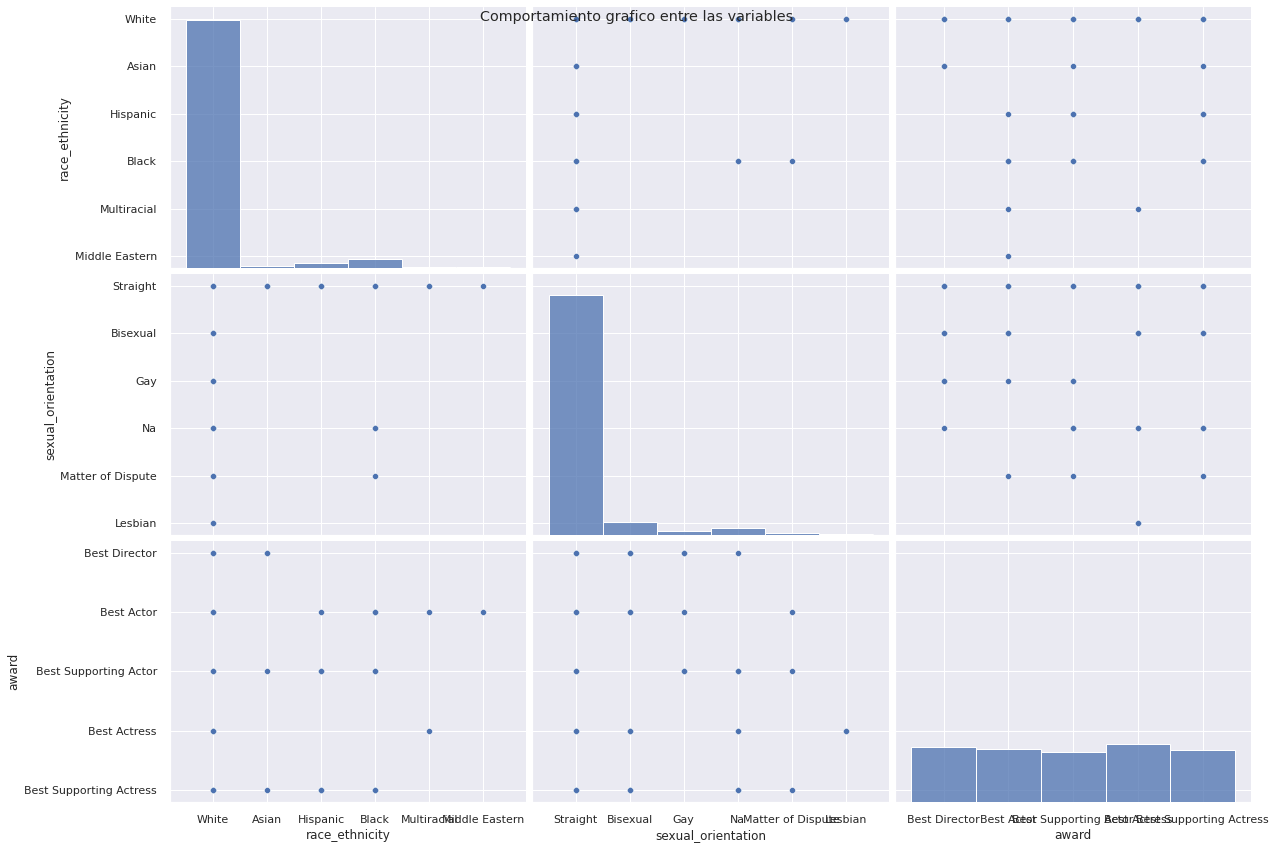

In [42]:
sns.set()
cols = ['race_ethnicity',	'sexual_orientation',	'award']
g_Dispercion = sns.pairplot(df, x_vars = cols, y_vars = cols, kind = 'scatter', height=4, aspect=1.5)
g_Dispercion.fig.suptitle('Comportamiento grafico entre las variables')
plt.show()

In [43]:
#Tranformadores para las variables necesarias. 
transformador1 = LabelEncoder()
transformador2 = LabelEncoder()
transformador3 = LabelEncoder()
transformador4 = LabelEncoder()
transformador5 = LabelEncoder()
#Transformacion de las variables.
dfa = df[['race_ethnicity']].apply(transformador1.fit_transform)
dfb = df[['religion']].apply(transformador2.fit_transform)
dfc = df[['sexual_orientation']].apply(transformador3.fit_transform)
dfd = df[['award']].apply(transformador4.fit_transform)
dfe = df[['Continent']].apply(transformador5.fit_transform)

In [44]:
#Eliminar columnas en el dataframe original para poder agregarlas tranformadas
df_copy = df
df = df.drop(columns = ['race_ethnicity', 'religion', 'sexual_orientation', 'award', 'movie', 'birthplace2', 'Continent'])
df = df.join(dfa)
df = df.join(dfb)
df = df.join(dfc)
df = df.join(dfd)
df = df.join(dfe)

In [45]:
df.head()

,birthplace,date_of_birth,year_of_award,person,year_of_birth,age_of_award,race_ethnicity,religion,sexual_orientation,award,Continent
0,"Chisinau, Moldova",1895-09-30,1927,Lewis Milestone,1895.0,32.0,5,15,5,2,2
1,"Glasgow, Scotland",1886-02-02,1930,Frank Lloyd,1886.0,44.0,5,15,5,2,2
2,"Chisinau, Moldova",1895-09-30,1931,Lewis Milestone,1895.0,36.0,5,15,5,2,2
3,"Chicago, Il",1899-02-23,1932,Norman Taurog,1899.0,33.0,5,15,5,2,3
4,"Salt Lake City, Ut",1894-04-23,1933,Frank Borzage,1894.0,39.0,5,19,5,2,3


In [46]:
# se revisa la correlacion de las variables
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,year_of_award,year_of_birth,age_of_award,race_ethnicity,religion,sexual_orientation,award,Continent
year_of_award,1.000000,0.876822,0.115134,-0.191501,-0.162548,0.093628,0.073398,0.091392
year_of_birth,0.876822,1.000000,-0.376666,-0.203694,-0.177341,0.081033,0.036784,0.102953
age_of_award,0.115134,-0.376666,1.000000,0.051876,0.053213,0.012974,0.065414,-0.036621
race_ethnicity,-0.191501,-0.203694,0.051876,1.000000,0.098660,-0.044963,-0.131471,0.051793
religion,-0.162548,-0.177341,0.053213,0.098660,1.000000,0.156571,-0.013639,-0.074972
sexual_orientation,0.093628,0.081033,0.012974,-0.044963,0.156571,1.000000,0.033017,-0.047808
award,0.073398,0.036784,0.065414,-0.131471,-0.013639,0.033017,1.000000,0.076488
Continent,0.091392,0.102953,-0.036621,0.051793,-0.074972,-0.047808,0.076488,1.000000


In [47]:
#Elimacion de las variables que no se usarán para el entrenamiento, debido a que son variables que no se necesitan, ya que estan representadas en otras columnas
df = df.drop(columns = ['birthplace', 'date_of_birth', 'year_of_birth', 'person', 'age_of_award'])

In [48]:
df.head()

,year_of_award,race_ethnicity,religion,sexual_orientation,award,Continent
0,1927,5,15,5,2,2
1,1930,5,15,5,2,2
2,1931,5,15,5,2,2
3,1932,5,15,5,2,3
4,1933,5,19,5,2,3


In [49]:
# se revisa la correlacion de las variables
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,year_of_award,race_ethnicity,religion,sexual_orientation,award,Continent
year_of_award,1.000000,-0.191501,-0.162548,0.093628,0.073398,0.091392
race_ethnicity,-0.191501,1.000000,0.098660,-0.044963,-0.131471,0.051793
religion,-0.162548,0.098660,1.000000,0.156571,-0.013639,-0.074972
sexual_orientation,0.093628,-0.044963,0.156571,1.000000,0.033017,-0.047808
award,0.073398,-0.131471,-0.013639,0.033017,1.000000,0.076488
Continent,0.091392,0.051793,-0.074972,-0.047808,0.076488,1.000000


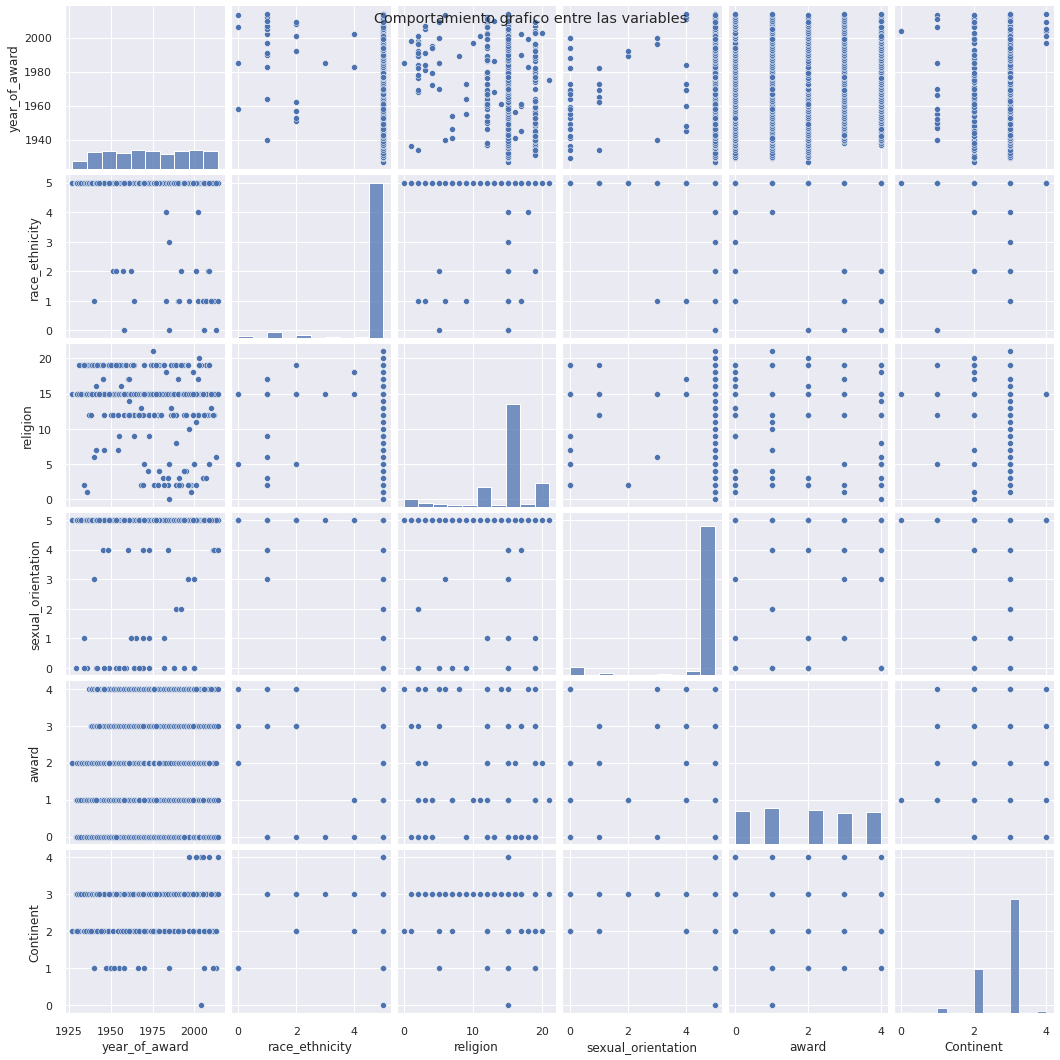

In [50]:
sns.set()
cols = ['year_of_award',	'race_ethnicity',	'religion',	'sexual_orientation',	'award', 'Continent']
g_Dispercion = sns.pairplot(df, x_vars = cols, y_vars = cols)
g_Dispercion.fig.suptitle('Comportamiento grafico entre las variables')
plt.show();


In [51]:
df.describe()

,year_of_award,race_ethnicity,religion,sexual_orientation,award,Continent
count,441.000000,441.000000,441.000000,441.000000,441.000000,441.000000
mean,1973.165533,4.755102,14.129252,4.646259,1.956916,2.678005
std,24.030895,0.943339,3.979388,1.189744,1.404685,0.568644
min,1927.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1953.000000,5.000000,15.000000,5.000000,1.000000,2.000000
50%,1973.000000,5.000000,15.000000,5.000000,2.000000,3.000000
75%,1994.000000,5.000000,15.000000,5.000000,3.000000,3.000000
max,2014.000000,5.000000,21.000000,5.000000,4.000000,4.000000


### Entranamiento modelo supervisado

In [52]:
#Tranformador de las variables a escalas parecidas
#Se hara el escalado para la varianza en 1
escalador = StandardScaler()
transformado = escalador.fit_transform(df)
transformado1 = pd.DataFrame(transformado)
transformado1.columns = df.columns
df = transformado1
df.head()

,year_of_award,race_ethnicity,religion,sexual_orientation,award,Continent
0,-1.923273,0.259902,0.219063,0.297663,0.030706,-1.193672
1,-1.798292,0.259902,0.219063,0.297663,0.030706,-1.193672
2,-1.756631,0.259902,0.219063,0.297663,0.030706,-1.193672
3,-1.714971,0.259902,0.219063,0.297663,0.030706,0.566894
4,-1.673311,0.259902,1.225384,0.297663,0.030706,0.566894


In [53]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
year_of_award,441.0,1.578984e-15,1.001136,-1.923273,-0.840103,-0.006896,0.867971,1.701179
race_ethnicity,441.0,3.262696e-16,1.001136,-5.046438,0.259902,0.259902,0.259902,0.259902
religion,441.0,-1.852889e-16,1.001136,-3.554642,0.219063,0.219063,0.219063,1.728545
sexual_orientation,441.0,3.746059e-16,1.001136,-3.909693,0.297663,0.297663,0.297663,0.297663
award,441.0,0.000000e+00,1.001136,-1.394718,-0.682006,0.030706,0.743418,1.456130
Continent,441.0,1.450087e-16,1.001136,-4.714806,-1.193672,0.566894,0.566894,2.327461


In [54]:
#SE hace el analisis del peso de los componentes dentro del data frame, viendo con cuantos componentes nos ayuda a identificar en comportamiento del dataframe
pca = PCA(n_components=6) # Establecemos el PCA de todos los componentes (se agregan la totalidad de los componentes, 6)
df1 = pca.fit_transform(df) # Lo aplicamos a nuestro dataset codificado
pca.explained_variance_ratio_.cumsum() # Calculamos las varianzas acumuladas explicadas. Esto nos da que, al llegar a mas del 85% podriamos decir que el Data
                                       # frame podría estar representado. Trabajaremos con el 88%, que implica que 5 componentes, explican el dataframe

array([0.22905959, 0.42501828, 0.59568711, 0.75434819, 0.88164588,
       1.        ])

In [55]:
pca.explained_variance_ratio_

array([0.22905959, 0.19595868, 0.17066883, 0.15866108, 0.12729769,
       0.11835412])

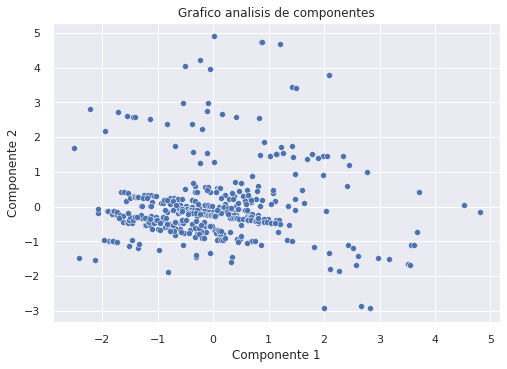

In [56]:
pca = PCA(n_components=5) # Establecemos el PCA de 5 componentes 
pcs = pca.fit_transform(df) # Lo aplicamos a nuestro dataset codificado

# Gráficamos
plt.title('Grafico analisis de componentes')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
pc1_values = pcs[:,0]
pc2_values = pcs[:,1]
sns.scatterplot(x=pc1_values, y=pc2_values)

#La grafica nos muestra como se van agrupando, poco a poco, los datos.

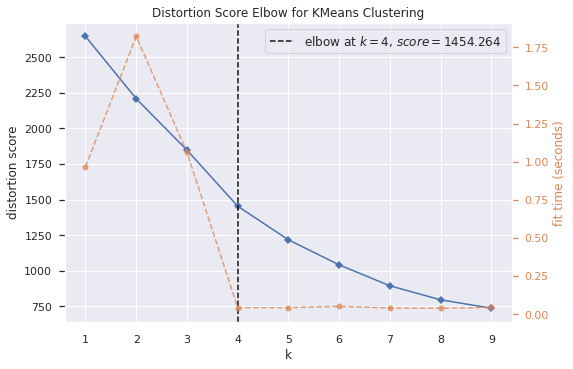

In [57]:
#Se realiza un analisis de codo, el cual nos ayuda a determinar el mejor numero de clusters (K), para un Kmeans
X = df.values 
# Inicializamos el modelo y el visualizador
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 10))

visualizer.fit(X) # Hacemos fit a los datos en el visualizados
visualizer.show() # Renderizamos la figura y la mostramos

In [58]:
scoringClusterValidation(10, df, AgglomerativeClustering)

    K  Siluete-score  Calinski-Harabasz  Davies-Bouldin
0   2       0.441412          89.828732        1.040394
1   3       0.455708         109.915725        0.992805
2   4       0.266790         121.445557        1.255190
3   5       0.301113         126.053804        1.127436
4   6       0.286584         134.919268        1.075193
5   7       0.270604         133.579431        0.976062
6   8       0.296297         133.443350        0.997841
7   9       0.301721         131.174710        1.018172
8  10       0.287070         129.927328        1.013144
9  11       0.290960         127.908150        1.020089
------------------------------------------------------------------
El valor del Siluete es 3
El valor Calinski-Harabasz es 6
El valor Davies-Bouldin es 7
------------------------------------------------------------------
Valores K
3            1
6            1
7            1
dtype: int64


In [59]:
scoringClusterValidation(10, df, KMeans)

    K  Siluete-score  Calinski-Harabasz  Davies-Bouldin
0   2       0.448129          90.131547        1.017179
1   3       0.457098         110.168473        0.984576
2   4       0.266925         111.570768        1.374821
3   5       0.269851         128.215075        1.214052
4   6       0.298144         139.757172        1.049188
5   7       0.293618         141.370990        0.993650
6   8       0.317697         143.565262        0.992685
7   9       0.321682         139.547852        1.018090
8  10       0.307450         138.767114        1.021647
9  11       0.316455         135.684282        1.047028
------------------------------------------------------------------
El valor del Siluete es 3
El valor Calinski-Harabasz es 8
El valor Davies-Bouldin es 3
------------------------------------------------------------------
Valores K
3            2
4            1
8            1
dtype: int64


## Resultados

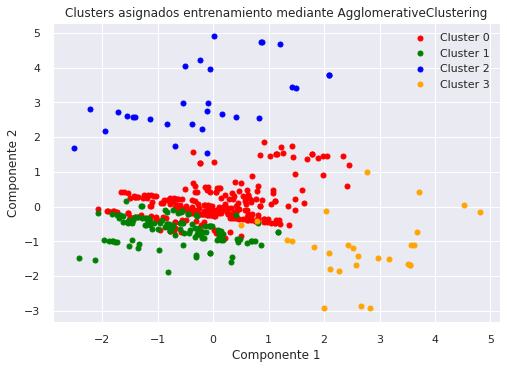

In [60]:
#Entrenamiento del modelo con metodo de Clusteris Agglomerativo
n_clusters=4
hc = AgglomerativeClustering(n_clusters = n_clusters, affinity = "euclidean", linkage = "ward")
y_hc = hc.fit_predict(df1)
df2 = np.array(df1) # para poder realizar una grafica de dispercion, el dataframe se pondrá en un array

#Se hace un diagrama de dispersion de las variables que representan el dataframe, coloreados, según el cluster asignado
colores = ['red', 'green', 'blue', 'orange', 'pink', 'violet', 'black', 'brown', 'magenta', 'cyan'] #Lista de 10 colores (se pueden graficar hasta 10 clusteres)
cluster = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8', 'Cluster 9'] #Lista de 10 cluster
#Un For para graficar un Kmeans con un K de 1 a 10.
for i in range(n_clusters):
  plt.scatter(df2[y_hc == i, 0], df2[y_hc == i, 1], s = 100, marker= '.', c = colores[i], label = cluster[i])

plt.legend()
plt.title('Clusters asignados entrenamiento mediante AgglomerativeClustering')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

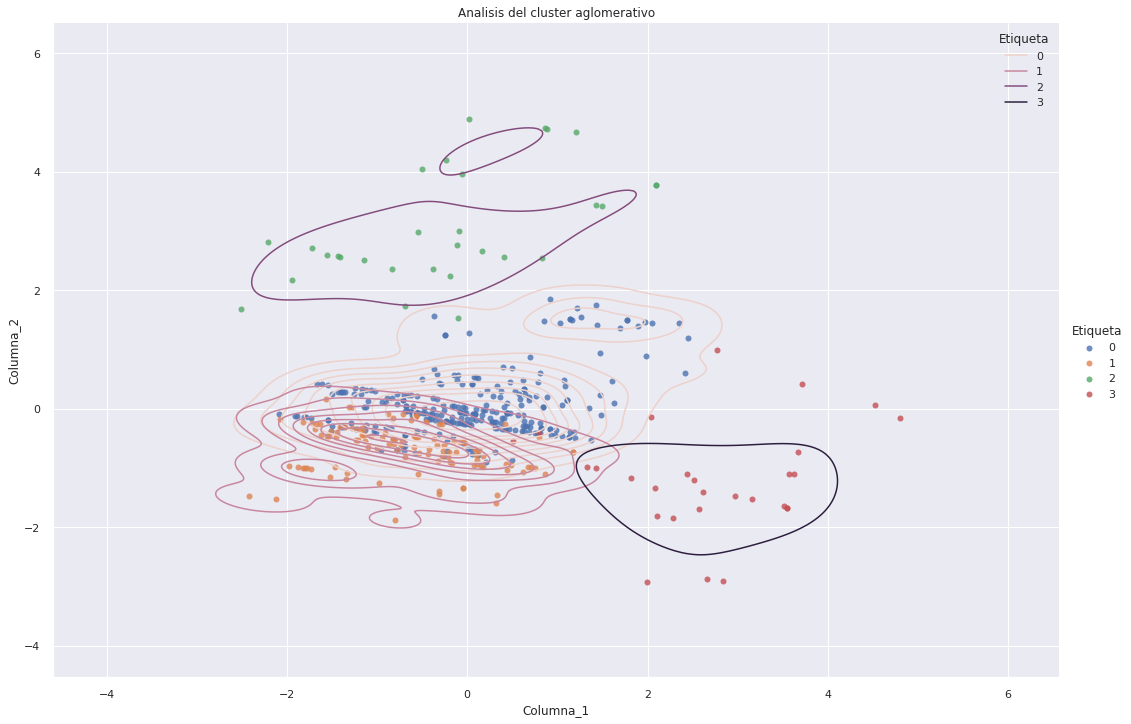

In [61]:
#Revision de la densidad de los grupos generados, segun el clusterin agglomerativo
pca = PCA(2)
data = pca.fit_transform(df2)
df = pd.DataFrame(data, columns= ['Columna_1', 'Columna_2'])
df['Etiqueta'] = y_hc
sns.lmplot(data= df, x= 'Columna_1', y= 'Columna_2', hue= 'Etiqueta', fit_reg= False, height=10, aspect=1.5).set(title='Analisis del cluster aglomerativo')
sns.kdeplot(data= df, x= 'Columna_1', y= 'Columna_2', hue= 'Etiqueta')
plt.show()

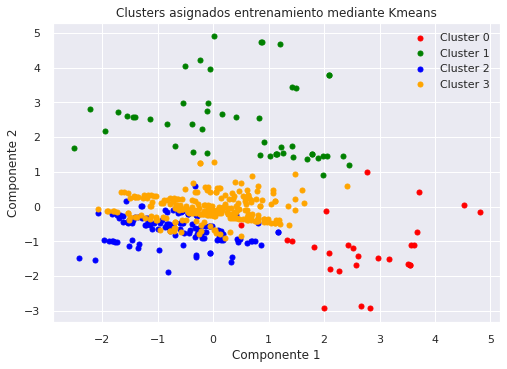

In [62]:
#Entrenamiento del modelo con metodo KMeans
# segun el analisis de codo, el K ideal es 4, son 4 clusters que se dividirá el dataframe
km = 4
kmeans = KMeans(n_clusters = km, init="k-means++", max_iter = 300, n_init = 10, random_state = 2)
y_kmeans = kmeans.fit_predict(df1)
labels = kmeans.labels_ #Con esto obtenemos a qué cluster corresponde cada fila.
df2 = np.array(df1) # para poder realizar una grafica de dispercion, el dataframe se pondrá en un array

#Se hace un diagrama de dispersion de las variables que representan el dataframe, coloreados, según el cluster asignado
colores = ['red', 'green', 'blue', 'orange', 'pink', 'violet', 'black', 'brown', 'magenta', 'cyan'] #Lista de 10 colores (se pueden graficar hasta 10 clusteres)
cluster = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8', 'Cluster 9'] #Lista de 10 cluster
#Un For para graficar un Kmeans con un K de 1 a 10.
for i in range(km):
  plt.scatter(df2[y_kmeans == i, 0], df2[y_kmeans == i, 1], s = 100, marker= '.', c = colores[i], label = cluster[i])

plt.legend()
plt.title('Clusters asignados entrenamiento mediante Kmeans')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

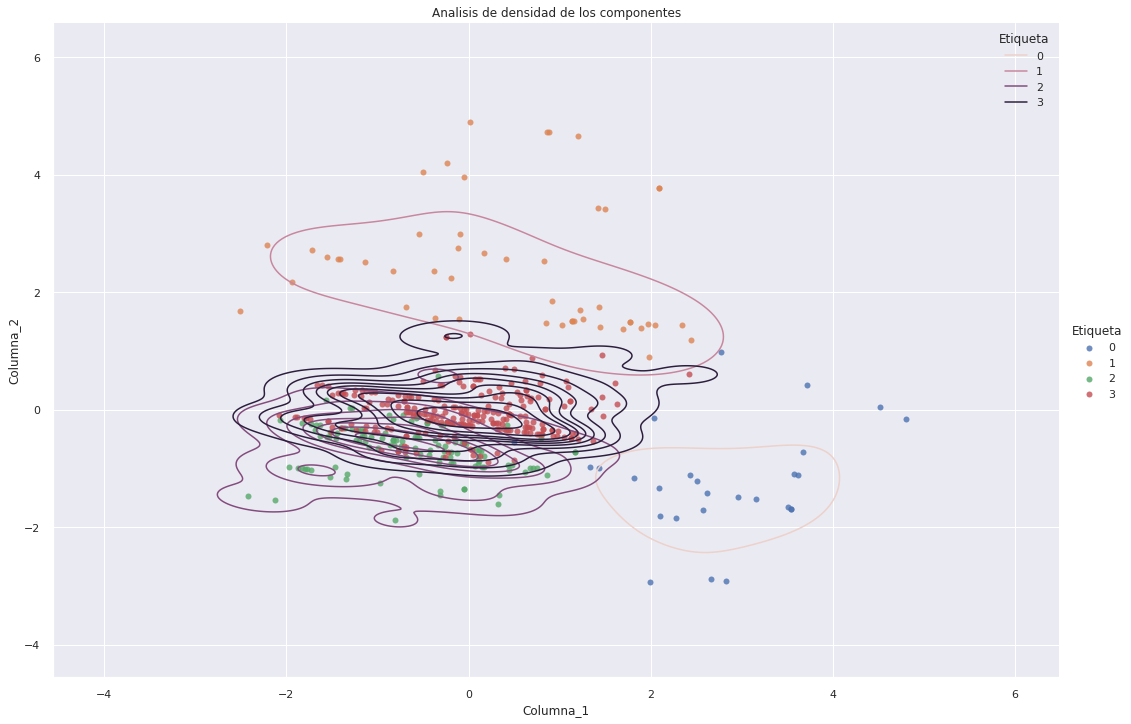

In [63]:
#Revision de la densidad de los grupos generados, segun KMEans
pca = PCA(2)
data = pca.fit_transform(df2)
df = pd.DataFrame(data, columns= ['Columna_1', 'Columna_2'])
df['Etiqueta'] = labels
sns.lmplot(data= df, x= 'Columna_1', y= 'Columna_2', hue= 'Etiqueta', fit_reg= False, height=10, aspect=1.5).set(title='Analisis de densidad de los componentes')
sns.kdeplot(data= df, x= 'Columna_1', y= 'Columna_2', hue= 'Etiqueta')
plt.show()

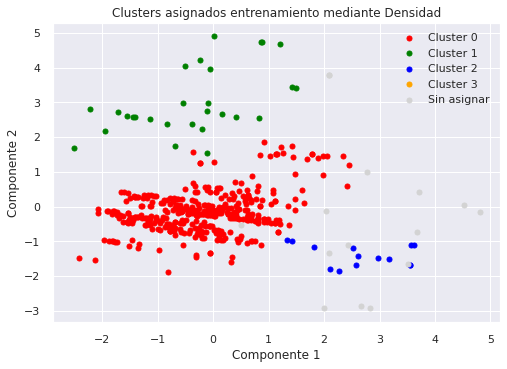

In [64]:
#Entrenamiento del modelo con metodo DBScan
density = DBSCAN(eps= 2, min_samples= 4, metric= 'euclidean')
y_density = density.fit_predict(df1)
df2 = np.array(df1) # para poder realizar una grafica de dispercion, el dataframe se pondrá en un array
#Se hace un diagrama de dispersion de las variables que representan el dataframe, coloreados, según el cluster asignado
colores = ['red', 'green', 'blue', 'orange', 'pink', 'violet', 'black', 'brown', 'magenta', 'cyan'] #Lista de 10 colores (se pueden graficar hasta 10 clusteres)
cluster = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5', 'Cluster 6', 'Cluster 7', 'Cluster 8', 'Cluster 9'] #Lista de 10 cluster
#Un For para graficar un Kmeans con un K de 1 a 10.
for i in range(n_clusters):
  
  plt.scatter(df2[y_density  == i, 0], df2[y_density  == i, 1], s = 100, marker= '.', c = colores[i], label = cluster[i])
  y_density 
plt.scatter(df2[y_density  == -1, 0], df2[y_density  == -1, 1], s = 100, marker= '.',c = "lightgray", label = "Sin asignar")
plt.legend()
plt.title('Clusters asignados entrenamiento mediante Densidad')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.show()

In [65]:
#Funcion que ayuda a encontrar el numero de elementos existentes en una lista
def buscar_n_elemento(lista, e):
   contador=0
   for i in lista:
      if i == e:
         contador+=1
   return contador
a = buscar_n_elemento(y_density, -1)
print(a, 'datos no fueron asignados' )


15 datos no fueron asignados


In [66]:
#Asignacion de los grupos al dataFrame original, En este caso se hace eligen los grupos entrenados por medio del AgglomerativeClustering
df_copy["Grupos"] = labels

In [67]:
df_copy.sort_values(by=['Grupos', 'award','year_of_award','Grupos','religion'])

,birthplace,date_of_birth,race_ethnicity,religion,sexual_orientation,year_of_award,award,movie,person,year_of_birth,age_of_award,birthplace2,Continent,Grupos
109,"Santurce, Puerto Rico",2009-01-08,Hispanic,Na,Straight,1951,Best Actor,Cyrano de Bergerac,Jose Ferrer,1909.0,42.0,Puerto Rico,North America,0
122,"Miami, Fl",2027-02-20,Black,Deist,Straight,1964,Best Actor,Lilies of the Field,Sidney Poitier,1927.0,37.0,United States of America,North America,0
160,"Mount Vernon, Ny",2054-12-28,Black,Protestant,Straight,2002,Best Actor,Training Day,Denzel Washington,1954.0,48.0,United States of America,North America,0
163,"Terrell, Tx",2067-12-13,Black,Baptist,Straight,2005,Best Actor,Ray,Jamie Foxx,1967.0,38.0,United States of America,North America,0
165,"Longview, Tx",2061-07-15,Black,Na,Straight,2007,Best Actor,The Last King of Scotland,Forest Whitaker,1961.0,46.0,United States of America,North America,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,"Catskill Mountains, Ny",2070-12-12,White,Jewish,Straight,2002,Best Supporting Actress,A Beautiful Mind,Jennifer Connelly,1970.0,32.0,United States of America,North America,3
405,"Katy, Tx",2069-04-25,White,Na,Straight,2004,Best Supporting Actress,Cold Mountain,RenÌ©e Zellweger,1969.0,35.0,United States of America,North America,3
406,"Melbourne, Victoria, Australia",2069-05-14,White,Na,Straight,2005,Best Supporting Actress,The Aviator,Cate Blanchett,1969.0,36.0,Australia,Oceania,3
412,New York City,2060-09-14,White,Na,Straight,2011,Best Supporting Actress,The Fighter,Melissa Leo,1960.0,51.0,United States of America,North America,3


In [68]:
df_copy[df_copy['Grupos']==1]

,birthplace,date_of_birth,race_ethnicity,religion,sexual_orientation,year_of_award,award,movie,person,year_of_birth,age_of_award,birthplace2,Continent,Grupos
7,"Cape Elizabeth, Me",1894-02-01,White,Roman Catholic,Bisexual,1936,Best Director,The Informer,John Ford,1894.0,42.0,United States of America,North America,1
12,"Cape Elizabeth, Me",1894-02-01,White,Roman Catholic,Bisexual,1941,Best Director,The Grapes of Wrath,John Ford,1894.0,47.0,United States of America,North America,1
13,"Cape Elizabeth, Me",1894-02-01,White,Roman Catholic,Bisexual,1942,Best Director,How Green Was My Valley,John Ford,1894.0,48.0,United States of America,North America,1
17,New York City,2018-10-11,White,Jewish,Gay,1962,Best Director,West Side Story,Jerome Robbins,1918.0,44.0,United States of America,North America,1
25,"Cape Elizabeth, Me",1894-02-01,White,Roman Catholic,Bisexual,1953,Best Director,The Quiet Man,John Ford,1894.0,59.0,United States of America,North America,1
31,"Chicago, Il",1903-02-28,White,Na,Bisexual,1959,Best Director,Gigi,Vincente Minnelli,1903.0,56.0,United States of America,North America,1
36,"Shipley, Yorkshire, England",2028-06-05,White,Na,Bisexual,1964,Best Director,Tom Jones,Tony Richardson,1928.0,36.0,United Kingdom,Europe,1
37,New York City,1899-07-07,White,Na,Gay,1965,Best Director,My Fair Lady,George Cukor,1899.0,66.0,United States of America,North America,1
43,"London, England",2026-02-16,White,Na,Gay,1969,Best Director,Midnight Cowboy,John Schlesinger,1926.0,43.0,United Kingdom,Europe,1
55,"Richmond, Va",2037-03-30,White,Baptist,Straight,1981,Best Director,Reds,Warren Beatty,1937.0,44.0,United States of America,North America,1


In [69]:
#Creacion de los archivos PKL, para ser exportados y utilizados en una API para produccion
import pickle

pickle.dump(hc, open('agglomerative.pkl', 'wb'))
pickle.dump(kmeans, open('kmeans.pkl', 'wb'))
pickle.dump(transformador1, open('transformador1.pkl', 'wb'))
pickle.dump(transformador2, open('transformador2.pkl', 'wb'))
pickle.dump(transformador3, open('transformador3.pkl', 'wb'))
pickle.dump(transformador4, open('transformador4.pkl', 'wb'))
pickle.dump(transformador5, open('transformador5.pkl', 'wb'))
pickle.dump(escalador, open('escalador.pkl', 'wb'))

## Codigo API


### Entorno local
Programa utilizado, SPIDER, de Anaconda
Los archivos .pkl tienen que ser puestos en la carpeta donde se necesiten extraer, con la ruta exacta

In [ ]:
from flask import Flask
from flask_restx import Api, Resource, fields
import numpy as np
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
#from sklearn.ensemble import RandomForestClassifier

app = Flask(__name__)

api = Api(app,
          title='Generación predicción',
          descripcion='Api para la predicción de supervivencia en el titanic')

ns = api.namespace('predict',description='Generación de predicción')

parser = api.parser()

parser.add_argument(
    'Year_of_award',
    type=int,
    required=True,
    help='Año en que se da el premio',
    location='args')

parser.add_argument(
    'Place_Of_Birth',
    choices=['North America', 'Europe', 'Asia', 'Oceania', 'Africa'],
    type=str,
    required=True,
    help='Lugar de nacimiento',
    location='args')

parser.add_argument(
    'Race_etthnicity',
    choices=['White','Black','Hispanic','Asian','Multiracial','Middle Eastern'],
    type=str,
    required=True,
    help='Raza etnica',
    location='args')

parser.add_argument(
    'Religion',
    choices=['Na',
             'Roman Catholic',
             'Jewish',
             'Atheist',
             'Born-Again Christian',
             'Baptist',
             'Buddhist',
             'Protestant',
             'Christian Science',
             'Deist',
             'Lutheran',
             'Christian',
             'Quaker',
             'Anglican/episcopalian',
             'Presbyterian',
             'Sufism',
             'Disciples of Christ',
             'Hindu',
             'Methodist',
             'Agnostic',
             'Congregationalist',
             ],
    type=str,
    required=True,
    help='Religion que predica',
    location='args')

parser.add_argument(
    'Sexual_orientation',
    choices=['Straight','Bisexual','Na','Gay','Matter of Dispute','Lesbian',],
    type=str,
    required=True,
    help='Orientacion sexual',
    location='args')

parser.add_argument(
    'Award',
    choices=['Best Actress','Best Director','Best Actor','Best Supporting Actress','Best Supporting Actor',],
    type=str,
    required=True,
    help='Precio del tiquete pagado',
    location='args')

resource_fields = api.model('Resource', {'respuesta': fields.String,})

def pred(Year_of_award,Place_Of_Birth,Race_etthnicity,Religion,Sexual_orientation,Award):
    #arreglo = np.array([[Year_of_award,Place_Of_Birth,Place_Of_Birth,Race_etthnicity,Religion,Sexual_orientation,Award]])
    #arreglo = np.array([Place_Of_Birth])
    classifier = pickle.load(open(r"C:\Users\MI PC\Google Drive\1. DataScienci\proyectoModulo_7\kmeans.pkl", 'rb'))
    t1 = pickle.load(open(r"C:\Users\MI PC\Google Drive\1. DataScienci\proyectoModulo_7\transformador1.pkl", 'rb'))
    t2 = pickle.load(open(r"C:\Users\MI PC\Google Drive\1. DataScienci\proyectoModulo_7\transformador2.pkl", 'rb'))
    t3 = pickle.load(open(r"C:\Users\MI PC\Google Drive\1. DataScienci\proyectoModulo_7\transformador3.pkl", 'rb'))
    t4 = pickle.load(open(r"C:\Users\MI PC\Google Drive\1. DataScienci\proyectoModulo_7\transformador4.pkl", 'rb'))
    t5 = pickle.load(open(r"C:\Users\MI PC\Google Drive\1. DataScienci\proyectoModulo_7\transformador5.pkl", 'rb'))
    s1 = pickle.load(open(r"C:\Users\MI PC\Google Drive\1. DataScienci\proyectoModulo_7\escalador.pkl", 'rb'))
    #classifier = pickle.load(open(r"C:\Users\MI PC\Google Drive\1. DataScienci\ucamp\ucamp\classifier.pkl", 'rb'))
     
    Place_Of_Birth = t5.transform([Place_Of_Birth])
    Race_etthnicity = t1.transform([Race_etthnicity])
    Religion = t2.transform([Religion])
    Sexual_orientation = t3.transform([Sexual_orientation])
    Award = t4.transform([Award])
    arreglo = np.array([Year_of_award,Race_etthnicity[0],Religion[0],Sexual_orientation[0],Award[0],Place_Of_Birth[0]])
    arreglo = pd.DataFrame([arreglo])
    arreglo = s1.transform(arreglo)
    pred = classifier.predict(arreglo)  
    if pred == 0:
        respuesta = "Grupo 0"
    elif pred == 1:
        respuesta = "Grupo 1"
    elif pred == 2:
        respuesta = "Grupo 2"
    elif pred == 3:
        respuesta = "Grupo 3"
    else:
        respuesta = pred
    return respuesta

@ns.route('/')
class DSApi(Resource):
    @api.doc(parser=parser)
    @api.marshal_with(resource_fields)
    
    def get(self):
        args = parser.parse_args()
        return {'respuesta':pred(args.Year_of_award,args.Place_Of_Birth,args.Race_etthnicity,args.Religion,args.Sexual_orientation,args.Award)},200

if __name__ == "__main__":
     app.run(debug=True,use_reloader=False,port=5000)


### Entorno WEB
Pagina web utilizada, PythonAnywhere. al ser gratuita, solo esta "en produccion" por 3 meses.

Los archivos deben cargarse en la pagina web

In [ ]:
from flask import Flask
from flask_restx import Api, Resource, fields
import numpy as np
import pickle
import pandas as pd
from sklearn.preprocessing import StandardScaler
#from sklearn.ensemble import RandomForestClassifier

app = Flask(__name__)

api = Api(app,
          title='Generación predicción',
          descripcion='Api para la predicción de supervivencia en el titanic')

ns = api.namespace('predict',description='Generación de predicción')

parser = api.parser()

parser.add_argument(
    'Year_of_award',
    type=int,
    required=True,
    help='Año en que se da el premio',
    location='args')

parser.add_argument(
    'Place_Of_Birth',
    choices=['North America', 'Europe', 'Asia', 'Oceania', 'Africa'],
    type=str,
    required=True,
    help='Lugar de nacimiento',
    location='args')

parser.add_argument(
    'Race_etthnicity',
    choices=['White','Black','Hispanic','Asian','Multiracial','Middle Eastern'],
    type=str,
    required=True,
    help='Raza etnica',
    location='args')

parser.add_argument(
    'Religion',
    choices=['Na',
             'Roman Catholic',
             'Jewish',
             'Atheist',
             'Born-Again Christian',
             'Baptist',
             'Buddhist',
             'Protestant',
             'Christian Science',
             'Deist',
             'Lutheran',
             'Christian',
             'Quaker',
             'Anglican/episcopalian',
             'Presbyterian',
             'Sufism',
             'Disciples of Christ',
             'Hindu',
             'Methodist',
             'Agnostic',
             'Congregationalist',
             ],
    type=str,
    required=True,
    help='Religion que predica',
    location='args')

parser.add_argument(
    'Sexual_orientation',
    choices=['Straight','Bisexual','Na','Gay','Matter of Dispute','Lesbian',],
    type=str,
    required=True,
    help='Orientacion sexual',
    location='args')

parser.add_argument(
    'Award',
    choices=['Best Actress','Best Director','Best Actor','Best Supporting Actress','Best Supporting Actor',],
    type=str,
    required=True,
    help='Precio del tiquete pagado',
    location='args')

resource_fields = api.model('Resource', {'respuesta': fields.String,})

def pred(Year_of_award,Place_Of_Birth,Race_etthnicity,Religion,Sexual_orientation,Award):
    #arreglo = np.array([[Year_of_award,Place_Of_Birth,Place_Of_Birth,Race_etthnicity,Religion,Sexual_orientation,Award]])
    #arreglo = np.array([Place_Of_Birth])
    classifier = pickle.load(open("kmeans.pkl", 'rb'))
    t1 = pickle.load(open("transformador1.pkl", 'rb'))
    t2 = pickle.load(open("transformador2.pkl", 'rb'))
    t3 = pickle.load(open("transformador3.pkl", 'rb'))
    t4 = pickle.load(open("transformador4.pkl", 'rb'))
    t5 = pickle.load(open("transformador5.pkl", 'rb'))
    s1 = pickle.load(open("escalador.pkl", 'rb'))
    #classifier = pickle.load(open(r"C:\Users\MI PC\Google Drive\1. DataScienci\ucamp\ucamp\classifier.pkl", 'rb'))

    Place_Of_Birth = t5.transform([Place_Of_Birth])
    Race_etthnicity = t1.transform([Race_etthnicity])
    Religion = t2.transform([Religion])
    Sexual_orientation = t3.transform([Sexual_orientation])
    Award = t4.transform([Award])
    arreglo = np.array([Year_of_award,Race_etthnicity[0],Religion[0],Sexual_orientation[0],Award[0],Place_Of_Birth[0]])
    arreglo = pd.DataFrame([arreglo])
    arreglo = s1.transform(arreglo)
    pred = classifier.predict(arreglo)
    if pred == 0:
        respuesta = "Grupo 0"
    elif pred == 1:
        respuesta = "Grupo 1"
    elif pred == 2:
        respuesta = "Grupo 2"
    elif pred == 3:
        respuesta = "Grupo 3"
    else:
        respuesta = pred
    return respuesta

@ns.route('/')
class DSApi(Resource):
    @api.doc(parser=parser)
    @api.marshal_with(resource_fields)

    def get(self):
        args = parser.parse_args()
        return {'respuesta':pred(args.Year_of_award,args.Place_Of_Birth,args.Race_etthnicity,args.Religion,args.Sexual_orientation,args.Award)},200

import os

if __name__ == '__main__':
    app.run(host=os.getenv('IP', '0.0.0.0'), port=int(os.getenv('PORT', 4444)))

